<a href="https://colab.research.google.com/github/Varhcsa/Train-test/blob/main/Submit1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Module for Google Drive
from google.colab import drive

# Module for Importing Images
from PIL import Image 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.10.0+cu111


### Import your drive's contents!

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Let's define some path, and our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the train/test path to "train_path" and "test_path"
- To 'model_dir', put the drive's directory path that you want to save your model

In [ ]:
train_path = './drive/MyDrive/Dataset0/pokemon/train' 
test_path = './drive/MyDrive/Dataset0/pokemon/test'
model_dir = './drive/MyDrive/Codes/models'    #./drive/MyDrive/Path/To/Save/Your/Model
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

In [ ]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

        # Add some tranforms for data augmentation.
        self.Flip = torchvision.transforms.RandomHorizontalFlip(p=0.5)
        self.Crop = torchvision.transforms.RandomCrop(90)
        self.Rotat = torchvision.transforms.RandomRotation(50,expand=True)
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
        self.all_transform=torchvision.transforms.Compose([self.Crop,
                                 torchvision.transforms.Resize((120,120)),     
                               self.tensor_transform,
                               self.normalize_transform 
                               ])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        #input = self.all_transform(original_img)
        input = self.all_transform(img)
        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

### Set DataSet and DataLoader

In [ ]:
batch_size = 64

train_dataset = PokemonDataset(train_path, classes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = PokemonDataset(test_path, classes)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(classes)

### Take a sample and try to look at the one

In [ ]:
sample = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


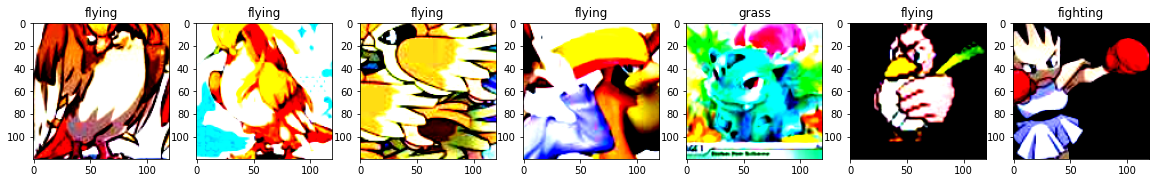

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['class_name'][i])

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Define the model with the pre-trained ResNet

In [ ]:
class Model(nn.Module):
    def __init__(self, feat_dim = 2048, output_dim =num_classes):
        super(Model, self).__init__()

        self.feat_dim = feat_dim
        self.output_dim = output_dim

        self.backbone = torchvision.models.resnet50(pretrained=True)

        self.backbone.fc = nn.Linear(feat_dim, output_dim)

        ct = 0
        for name, child in self.backbone.named_children():
          ct += 1
          if ct < 7:
            for name2, params in child.named_parameters():
              params.requires_grad = False
    def forward(self, img):
        out = self.backbone(img) 
        return out

### Create a model and its optimizer


In [ ]:
model = Model()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-6)

In [ ]:
model(sample['input'].to(device)).shape

torch.Size([64, 10])

### Define functions for train/test



In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    input = sample['input'].float().to(device)
    target = sample['target'].long().to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    top_val, top_idx = torch.topk(pred, 1)

    num_correct = torch.sum(top_idx == target.view(-1, 1))
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return pred_loss.item(), num_correct.item()

### Run Training with crossval


This was added

In [ ]:
from sklearn.model_selection import KFold
#def reset_weights(m):
 #   if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
  #      m.reset_parameters()

max_epoch = 10
save_stride = 5
tmp_path = './checkpoint.pth'
max_accu = -1

# Configuration options
k_folds = 5
num_epochs = 10
loss_function = nn.CrossEntropyLoss()

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold,(train_idx,test_idx) in enumerate(kfold.split(train_dataset)):
  print('------------fold no---------{}----------------------'.format(fold))
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
 

  trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)

  #trainloader = torch.utils.data.DataLoader(
   #                   train_dataset, 
   #                   batch_size=batch_size, sampler=train_subsampler)
  testloader = DataLoader(train_dataset,batch_size=batch_size, sampler=test_subsampler)
 
 # model.apply(reset_weights)
 
  for epoch in range(0, num_epochs):       
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    with tqdm(total=len(trainloader)) as pbar:
        for idx, sample in enumerate(trainloader):
            curr_loss, num_correct = train(model, optimizer, sample)
            train_loss += curr_loss / len(trainloader)
            train_accu += num_correct / len(train_dataset)
            pbar.update(1)

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
    torch.save(checkpoint, tmp_path)
    if (epoch+1) % save_stride == 0:
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_{}.pth'.format(epoch+1)))
    torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    with tqdm(total=len(testloader)) as pbar:
        for idx, sample in enumerate(testloader):
            curr_loss, num_correct = test(model, sample)
            test_loss += curr_loss / len(testloader)
            test_accu += num_correct / len(test_subsampler)
            pbar.update(1)


    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_best.pth'))

    # These Lines would make you update your Google Drive after the saving.
    drive.flush_and_unmount()
    drive.mount('/content/drive')

    print(train_accu, test_accu)

  #for epoch in range(1, max_epoch + 1):
   # train( model, optimizer,sample)
   # test(model,sample )

------------fold no---------0----------------------


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.12473483241408569 0.13559322033898302


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.13915994908782353 0.13347457627118645


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.16037335596096736 0.22245762711864406


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.23801442511667376 0.2838983050847458


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.31820110309715727 0.4173728813559322


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.38990241832838357 0.5423728813559321


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.45057276198557494 0.5932203389830509


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.44717861688587185 0.5783898305084747


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5048790835808231 0.6377118644067796


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5226983453542637 0.663135593220339


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5536699193890537 0.646186440677966


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5685193042002545 0.6864406779661016


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5787017394993637 0.7012711864406779


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6016122189223589 0.6483050847457626


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6202800169707255 0.6991525423728813


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.632583792957149 0.7521186440677966


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6499787865931269 0.7372881355932203


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.655918540517607 0.701271186440678


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6635553669919387 0.7372881355932204


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6779804836656766 0.7351694915254237


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6915570640644887 0.760593220338983


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6991938905388203 0.739406779661017


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7055579126007635 0.771186440677966


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7165888841747983 0.7584745762711864


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7174374204497237 0.7351694915254237


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7148918116249469 0.766949152542373


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7344081459482391 0.7627118644067797


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.738226559185405 0.7690677966101696


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7305897327110732 0.7203389830508474


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7399236317352563 0.7627118644067797


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7437420449724221 0.75


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7403478998727193 0.7754237288135593


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7594399660585488 0.7754237288135594


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7522274077216798 0.7542372881355932


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7556215528213829 0.7521186440677965


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7607127704709374 0.777542372881356


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7658039881204918 0.7754237288135593


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7564700890963085 0.7563559322033898


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7725922783198979 0.7923728813559322


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7624098430207888 0.7902542372881357
------------fold no---------1----------------------


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.10394569367840475 0.15677966101694918


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.14467543487484089 0.17796610169491525


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.16588884174798468 0.19703389830508475


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.20704285108188375 0.2542372881355932


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.2647433177768349 0.385593220338983


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.34450572761985576 0.4703389830508475


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.411964361476453 0.5190677966101694


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.4378447178616886 0.516949152542373


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.4819686041578279 0.5868644067796611


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5057276198557488 0.6588983050847458


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5383962664403902 0.6716101694915254


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5630038184132371 0.6504237288135593


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5736105218498092 0.6949152542372882


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5948239287229529 0.7076271186440678


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6126431904963938 0.7139830508474577


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6351294017819261 0.7097457627118644


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6393720831565549 0.6694915254237288


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.65931268561731 0.7076271186440678


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6669495120916418 0.722457627118644


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6669495120916419 0.7330508474576272


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6703436571913447 0.7415254237288135


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6868901145523968 0.7542372881355933


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6991938905388202 0.7436440677966102


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7119219346627066 0.7288135593220338


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7157403478998725 0.7415254237288137


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7051336444633004 0.7309322033898306


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7047093763258377 0.7605932203389831


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7263470513364444 0.7690677966101694


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7492575307594396 0.7817796610169492


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7543487484089941 0.7605932203389829


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7288926601612216 0.7733050847457628


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7445905812473482 0.7499999999999999


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7522274077216798 0.7775423728813559


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7607127704709372 0.7944915254237288


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7573186253712342 0.7542372881355931


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7607127704709374 0.766949152542373


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7653797199830289 0.7754237288135594


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7675010606703433 0.7754237288135593


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7704709376325835 0.788135593220339


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7543487484089941 0.7860169491525425
------------fold no---------2----------------------


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.1137038608400509 0.17834394904458598


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.13279592702588033 0.18471337579617833


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.14340263046245225 0.2038216560509554


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.16673737802291047 0.23779193205944796


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.21043699618158673 0.2908704883227176


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.2566822231650403 0.3227176220806794


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.2643190496393721 0.30148619957537154


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.36020364870598215 0.5031847133757962


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.41450997030123043 0.5456475583864119


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.45778532032244384 0.5520169851380042


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5150615188799321 0.5711252653927813


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5311837081035214 0.5923566878980892


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5647008909630886 0.6390658174097664


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5837929571489181 0.6645435244161358


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5795502757742894 0.5859872611464968


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6050063640220619 0.6581740976645435


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6062791684344506 0.6687898089171974


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6508273228680526 0.7006369426751592


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6554942723801441 0.7261146496815286


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6529486635553671 0.6900212314225053


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6542214679677553 0.7197452229299363


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6779804836656765 0.6751592356687898


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6885871871022484 0.7048832271762208


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7072549851506149 0.7197452229299363


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6894357233771741 0.6645435244161358


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.703860840050912 0.7346072186836518


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7144675434874839 0.7261146496815286


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7204072974119641 0.7452229299363057


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7187102248621127 0.732484076433121


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7259227831989815 0.732484076433121


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.734832414085702 0.751592356687898


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7526516758591427 0.7579617834394904


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7488332626219769 0.762208067940552


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.75519728468392 0.751592356687898


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.761985574883326 0.7855626326963906


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7619855748833259 0.7728237791932059


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7615613067458631 0.751592356687898


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7573186253712343 0.7537154989384288


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7632583792957146 0.7685774946921443


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7624098430207887 0.7643312101910827
------------fold no---------3----------------------


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.10564276622825625 0.15498938428874734


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.13279592702588033 0.15074309978768577


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.13449299957573188 0.1613588110403397


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.1845566397963513 0.2823779193205945


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.2664403903266865 0.3481953290870488


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.33050487908358067 0.48195329087048827


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.39881204921510405 0.5031847133757962


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.46627068307170133 0.5583864118895966


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.4794229953330505 0.554140127388535


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.4993635977938058 0.5668789808917197


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5248196860415782 0.5774946921443737


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5502757742893508 0.6008492569002123


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5502757742893508 0.6963906581740976


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5927025880356385 0.6454352441613588


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5825201527365295 0.673036093418259


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6236741620704286 0.7303609341825902


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.62537123462028 0.6963906581740976


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6347051336444635 0.732484076433121


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6622825625795501 0.7367303609341825


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6580398812049213 0.7261146496815286


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6677980483665676 0.7537154989384288


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6822231650403053 0.7558386411889596


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6907085277895629 0.7537154989384288


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6983453542638945 0.7452229299363057


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6996181586762832 0.7537154989384288


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6928298684768771 0.7176220806794055


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7000424268137461 0.732484076433121


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7136190072125582 0.7685774946921443


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7305897327110732 0.7707006369426751


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.731438268985999 0.7898089171974522


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7403478998727193 0.8259023354564755


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7433177768349594 0.7749469214437367


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7484089944845138 0.7855626326963906


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7492575307594397 0.7983014861995753


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7632583792957145 0.7940552016985137


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7551972846839198 0.8195329087048832


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7590156979210858 0.7791932059447982


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7645311837081032 0.7940552016985137


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7641069155706404 0.7961783439490445


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7628341111582517 0.791932059447983
------------fold no---------4----------------------


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.11327959270258806 0.16772823779193205


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.1302503182011031 0.15711252653927812


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.15316079762409843 0.25902335456475584


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.20873992363173519 0.3205944798301486


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.2655918540517607 0.39702760084925687


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.3241408570216376 0.4097664543524416


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.4026304624522698 0.49893842887473455


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.45311837081035217 0.5605095541401274


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.46287653797199835 0.5923566878980892


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.48027153160797637 0.6305732484076433


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5299109036911328 0.6348195329087049


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5303351718285956 0.5774946921443737


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5490029698769623 0.6539278131634819


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5829444208739921 0.6751592356687898


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.5736105218498091 0.6709129511677282


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6109461179465421 0.6985138004246284


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6325837929571488 0.732484076433121


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6368264743317777 0.6815286624203821


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6482817140432754 0.6772823779193206


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6550700042426812 0.7409766454352441


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6805260924904538 0.70276008492569


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6767076792532879 0.7197452229299363


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.6970725498515059 0.7452229299363057


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7034365719134491 0.7367303609341825


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7017394993635976 0.7600849256900212


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7161646160373354 0.732484076433121


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7178616885871868 0.751592356687898


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7314382689859987 0.7791932059447982


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.730589732711073 0.7876857749469214


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7352566822231649 0.7749469214437367


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7403478998727193 0.762208067940552


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7573186253712342 0.7600849256900212


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7522274077216797 0.7898089171974522


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.745014849384811 0.7876857749469214


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7564700890963085 0.81104033970276


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7594399660585486 0.7855626326963906


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.768349596945269 0.7940552016985137


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7602885023334744 0.7855626326963906


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7628341111582517 0.781316348195329


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Mounted at /content/drive
0.7670767925328805 0.8174097664543524


### Run Training without crossval

In [1]:
max_epoch = 10
save_stride = 5
tmp_path = './checkpoint.pth'
max_accu = -1
for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dataloader)) as pbar:
        for idx, sample in enumerate(train_dataloader):
            curr_loss, num_correct = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dataloader)
            train_accu += num_correct / len(train_dataset)
            pbar.update(1)

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
    torch.save(checkpoint, tmp_path)
    if (epoch+1) % save_stride == 0:
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_{}.pth'.format(epoch+1)))
    torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    with tqdm(total=len(test_dataloader)) as pbar:
        for idx, sample in enumerate(test_dataloader):
            curr_loss, num_correct = test(model, sample)
            test_loss += curr_loss / len(test_dataloader)
            test_accu += num_correct / len(test_dataset)
            pbar.update(1)


    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_best.pth'))

    # These Lines would make you update your Google Drive after the saving.
    drive.flush_and_unmount()
    drive.mount('/content/drive')

    print(train_accu, test_accu)

NameError: ignored

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
#